# Hands On "Observing the Earth from your Jupyter Notebook"

Ce notebook sert d'illustration et de démos d'outils de manipulation de données massives dans un contexte de cloud computing

## 1 - Chargement et visualisation d'images satellites avec xarray

Cette démo utilise les concepts que nous avons vu en cours pour charger une séries d'images temporelles

Nous allons voir en détail dans le prochain BE les concepts derrière les outils que nous utilisons

In [1]:
import datetime
import os
from pathlib import Path

import geogif
import numpy as np
import requests
import rioxarray
import xarray as xr
from rich import print

In [2]:
image_urls = [
    "https://storage.googleapis.com/fchouteau-isae-otsu/IMG_PHR1A_PMS_201504131053028_8bits.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/IMG_PHR1A_PMS_201506041053076_8bits.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/IMG_PHR1A_PMS_201609071056565_8bits.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/IMG_PHR1A_PMS_201707041049221_8bits.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/IMG_PHR1A_PMS_201908041045469_8bits.tif",
]


def download_file(in_url: str, out_filename: Path):
    if not (out_filename).exists():
        out_filename.parent.mkdir(exist_ok=True)
        print("Downloading", in_url)
        response = requests.get(in_url)
        with open(out_filename, "wb") as f:
            f.write(response.content)


for image_url in image_urls:
    download_file(image_url, Path() / "data" / image_url.split("/")[-1])

In [3]:
image_files = sorted(list(Path("data").glob("*.tif")))
print(image_files)

[
    PosixPath('data/IMG_PHR1A_PMS_201504131053028_8bits.tif'),
    PosixPath('data/IMG_PHR1A_PMS_201506041053076_8bits.tif'),
    PosixPath('data/IMG_PHR1A_PMS_201609071056565_8bits.tif'),
    PosixPath('data/IMG_PHR1A_PMS_201707041049221_8bits.tif'),
    PosixPath('data/IMG_PHR1A_PMS_201908041045469_8bits.tif')
]

### Chargement des images

On utilise [rioxarray](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-open-rasterio) pour ouvrir des images satellites en tant que tableau xarray/dask

In [4]:
def path_to_datetime(image_file):
    date = image_file.stem
    date = date.split("_")[-2][:8]
    date = datetime.datetime.strptime(date, "%Y%m%d")
    return date


timestamps = []
timeseries = []

for image_file in image_files:
    timestamps.append(path_to_datetime(image_file))
    img = rioxarray.open_rasterio(image_file, chunks=dict(x=512, y=512))
    img = img.assign_coords(coords=dict(band=["RED", "GREEN", "BLUE", "NIR"]))
    timeseries.append(img)

time_var = xr.Variable("time", timestamps)

timeseries = xr.concat(timeseries, dim=time_var)

Nous avons chargé les images en utilisant [rioxarray](https://corteva.github.io/rioxarray/stable/)

In [5]:
timeseries

<xarray.DataArray (time: 5, band: 4, y: 3520, x: 2560)>
dask.array<concatenate, shape=(5, 4, 3520, 2560), dtype=uint8, chunksize=(1, 4, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'RED' 'GREEN' 'BLUE' 'NIR'
  * x            (x) float64 3.734e+05 3.734e+05 ... 3.772e+05 3.772e+05
  * y            (y) float64 4.83e+06 4.83e+06 4.83e+06 ... 4.824e+06 4.824e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2015-04-13 2015-06-04 ... 2019-08-04
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
# Notons que la série temporelle est "lazy" car on a utilisé l'option "chunks" de open_rasterio
type(timeseries.data)

dask.array.core.Array

### Affichage de la série temporelle 

On utilise la fonction `.plot.imshow` de xarray

Vous pouvez explorer la [documentation](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html) pour rendre l'affichage plus joli

Zoom sur une vignette particulière de l'image globale (vous devriez reconnaître la zone)

In [7]:
timeseries = timeseries[:, :, 3100:3400, 2200:2500]
timeseries

<xarray.DataArray (time: 5, band: 4, y: 300, x: 300)>
dask.array<getitem, shape=(5, 4, 300, 300), dtype=uint8, chunksize=(1, 4, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'RED' 'GREEN' 'BLUE' 'NIR'
  * x            (x) float64 3.767e+05 3.767e+05 ... 3.771e+05 3.771e+05
  * y            (y) float64 4.825e+06 4.825e+06 ... 4.825e+06 4.825e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2015-04-13 2015-06-04 ... 2019-08-04
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

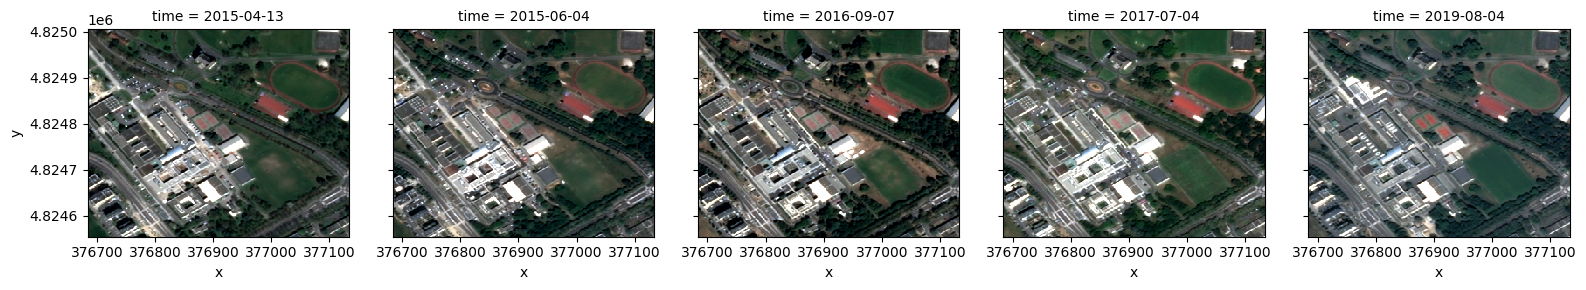

In [8]:
timeseries.sel(band=["RED", "GREEN", "BLUE"]).plot.imshow(col="time", robust=True)

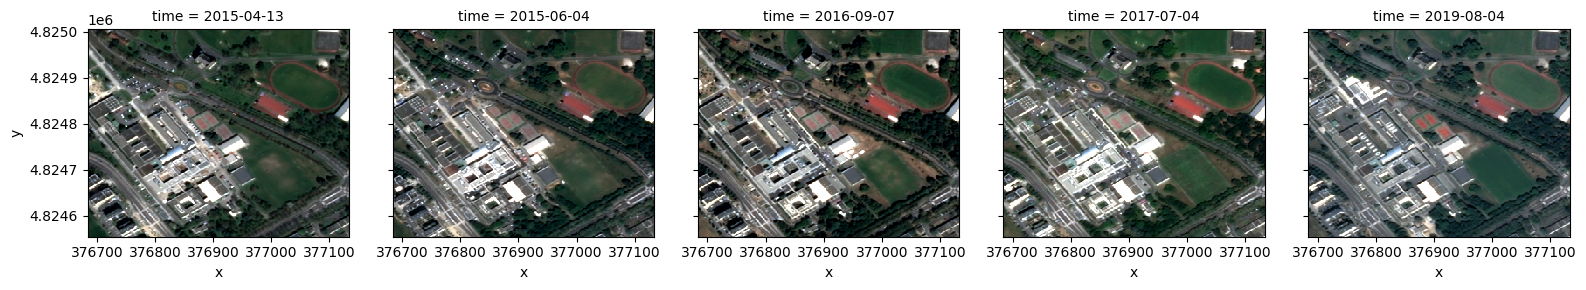

In [9]:
# Affichage de l'image RGB
timeseries.sel(band=["RED", "GREEN", "BLUE"]).plot.imshow(col="time", robust=True)

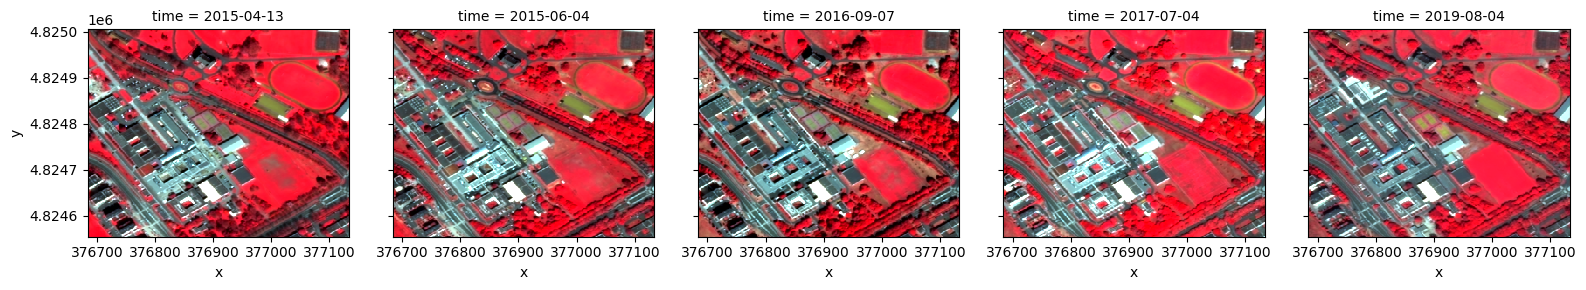

In [10]:
# Affichage de l'image fausses couleurs (PIR ROUGE VERT)
timeseries.sel(band=["NIR", "RED", "GREEN"]).plot.imshow(col="time", robust=True)

Création d'un GIF animé

In [ ]:
my_gif = geogif.dgif(timeseries.sel(band=["RED", "GREEN", "BLUE"]), fps=1)

In [ ]:
my_gif.compute()

### Calcul du NDVI

On utilise les fonctions xarray pour calculer le NDVI de notre série temporelle

In [ ]:
red = timeseries.sel(band=["RED"]).astype(np.float32) / 255.0
nir = timeseries.sel(band=["NIR"]).astype(np.float32) / 255.0
red = red.assign_coords(coords=dict(band=["NDVI"]))
nir = nir.assign_coords(coords=dict(band=["NDVI"]))

In [ ]:
# Notons encore une fois que le calcul n'est pas encore effectué
red

In [ ]:
nir

In [ ]:
ndvi = (nir - red) / (nir + red)

In [ ]:
ndvi

In [ ]:
ndvi = ndvi.sel(band=["NDVI"]).compute()

In [ ]:
geogif.gif(ndvi, fps=1, cmap="viridis")

## 2 - Création d'un gif d'images satellites à partir d'un catalogue cloud

Dans cette démo, nous allons manipuler les concepts "haut niveau" vu précédemment: 
- STAC
- XARRAY

En utilisant https://stackstac.readthedocs.io

Le but de cette démo est de rester "haut niveau" pour voir "l'état final des choses". 

Dans le prochain cours nous allons construire nous même tous les éléments un par un

In [ ]:
import json

import dask.utils
import geogif
import geojson
import geojsonio
import geopandas
import pystac_client
import shapely.geometry
import stackstac
from rasterio.enums import Resampling

### A la découverte des catalogues STAC

Tout d'abord nous allons nous connecter au catalog des images Sentinel 2 sur AWS 

https://registry.opendata.aws/sentinel-2-l2a-cogs/

❓ A quel catalogue accède-t-on ?

❓ Qu'est-ce qu'un catalogue [STAC](https://stacspec.org/en) ?

❓ Qu'est-ce qu'un produit [L2A](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) ?

In [ ]:
STAC_URL = "https://earth-search.aws.element84.com/v0"

Nous allons rechercher toutes les images centrées sur Toulouse (ou toute autre localisation que vous souhaitez).

Rendez-vous sur le site [geojson.io](http://geojson.io/#map=13/43.6043/1.4068) et dessinez une zone d'intérêt autour d'une zone de votre choix. Par exemple, Toulouse

Exemple: 

```python
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [1.3260841369628906, 43.54568641528668],
            [1.4970588684082031, 43.54568641528668],
            [1.4970588684082031, 43.651106046724365],
            [1.3260841369628906, 43.651106046724365],
            [1.3260841369628906, 43.54568641528668],
        ]
    ],
}
```

Ensuite, sélectionnez une plage temporelle

Exemple : 

```python
date_min, date_max = "2022-01-01", "2022-12-31"
```

In [ ]:
aoi = ...

date_min, date_max = ..., ...

Lançons une requête sur le catalogue STAC

In [ ]:
items = (
    pystac_client.Client.open(STAC_URL)
    .search(
        intersects=aoi,
        collections=["sentinel-s2-l2a-cogs"],
        datetime="{}/{}".format(date_min, date_max),
        limit=10_000,
    )
    .get_all_items()
)

Combien y-a-t-il d'images au catalogue ?

In [ ]:
len(items)

Explorons les "items" du catalogue

In [ ]:
from copy import deepcopy

import geopandas as gpd
import pandas as pd
from shapely.geometry import shape


# convert a list of STAC Items into a GeoDataFrame
def items_to_geodataframe(items):
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i["geometry"] = shape(_i["geometry"])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ["properties.datetime", "properties.created", "properties.updated"]:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index("properties.datetime", inplace=True)
    return gdf


# convert found items to a GeoDataFrame
items_gdf = items_to_geodataframe(items.to_dict()["features"])
items_gdf.head()

Affichage dans geojson.io (ouvrir le lien dans le navigateur)

In [ ]:
features = []

for date, row in items_gdf.iterrows():
    features.append(
        geojson.Feature(geometry=shapely.geometry.mapping(row.get("geometry")))
    )

link = geojsonio.display(features)

print(link)

### Chargement et traitement des images

On charge les items dans stackstac pour créer notre série temporelle.

Par défaut, le tableau créé est "lazy", c'est à dire que les images ne sont pas chargées en mémoire, mais qu'on manipule une "représentation" de l'image

In [ ]:
RESOLUTION = 50  # Resample to 50m to avoid heavy computations

In [ ]:
BOUNDS = shapely.geometry.shape(aoi).bounds

In [ ]:
stack = stackstac.stack(
    items,
    resolution=RESOLUTION,
    bounds_latlon=BOUNDS,
    resampling=Resampling.bilinear,
    assets=["B04", "B03", "B02"],
)

In [ ]:
stack

In [ ]:
type(stack.data)

Select the visibles bands in RGB order

In [ ]:
rgb = stack.sel(band=["B04", "B03", "B02"])
rgb

Faisons une série temporelle "composite" en utilisant la médiane par mois

In [ ]:
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

Maintenant, nous allons lancer le calcul de notre série temporelle. Notez que jusqu'alors l'array était "lazy" c'est à dire qu'on ne manipulait que des représentations.

Maintenant nous allons effectuer le calcul : 

In [ ]:
rgb = monthly_rgb.compute()

In [ ]:
rgb

On note que le tableau est maintenant en format numpy

In [ ]:
type(rgb.data)

On peut maintenant afficher les données

In [ ]:
rgb.plot.imshow(row="time", rgb="band", robust=True, size=6);

Transformons ceci dans un gif !

In [ ]:
gif = geogif.gif(rgb, fps=1, vmin=0, vmax=2048)

In [ ]:
gif

### Pour aller plus loin

Vous pouvez aller plus loin avec les tutoriaux suivants:

https://stackstac.readthedocs.io/en/latest/examples/index.html

https://stackstac.readthedocs.io/en/latest/examples/gif.html

https://stackstac.readthedocs.io/en/latest/basic.html

https://geogif.readthedocs.io/en/latest/index.html

Dans les prochains BE, nous allons voir les détails qui se cachent derrière tout ça !

D'autres lectures intéressantes

- https://examples.dask.org/array.html
- https://examples.dask.org/applications/satellite-imagery-geotiff.html
- https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/00_overview.html

## 3 - Exploration d'images satellites "cogeotif" dans le notebook jupyter

Nous allons utiliser localtileserver pour explorer des [cogeotifs](https://www.cogeo.org/) depuis le jupyter notebook

Cela permet de reproduire le fonctionnement "google maps" mais avec des propres images

Nous allons utiliser [localtileserver](https://github.com/banesullivan/localtileserver) et [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/)

❓ Pouvez-vous brièvement décrire ces technologies

In [ ]:
from ipyleaflet import Map
from localtileserver import TileClient, get_leaflet_tile_layer

Sélectionnez l'une des images que vous souhaitez visualiser

In [ ]:
image = "data/IMG_PHR1A_PMS_201908041045469_8bits.tif"

In [ ]:
# First, create a tile server from local raster file
client = TileClient(image)

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client)

m = Map(center=client.center(), zoom=client.default_zoom)
m.add_layer(t)
m

Magie ?